In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

samples like: 8 + 6 3 / 2 - 4 7 4 / 5 - 1 / 5 / 4 9 / 9 + 1 + 8 4 - 7 9 9 + 3 / 4 + 7 / 9 - 6 / 6 4 + 3 / 3 1 5 1 2 3 4 6 7 1 2 3 4 5 6 8 9 1 2 3 4 5 6 7 8 10 11 12 13 1 2 14 15 1 2 3 4 16 17 1 2 18 19 1 2 20 21 1 2 3 4 22 23 1 2 23 2

# sarnn

In [2]:
seq = '8 + 6 * 3 / 2 - 4 * 7 * 4 / 5 - 1 / 5 / 4 * 9 / 9 + 1 + 8 * 4 - 7 * 9 * 9 + 3 / 4 + 7 / 9 - 6 / 6 * 4 + 3 / 3'.split(' ')
seq_len = len(seq)
seq_len

55

In [3]:
ds = '1 5 1 2 3 4 6 7 1 2 3 4 5 6 8 9 1 2 3 4 5 6 7 8 10 11 12 13 1 2 14 15 1 2 3 4 16 17 1 2 18 19 1 2 20 21 1 2 3 4 22 23 1 2'.split(' ')
syn_dis = [int(d) for d in ds]

In [4]:
prob_action = {i:[] for i in range(seq_len)}
mem = {i:[] for i in range(seq_len)}

In [5]:
i = 0
nc = 0
nt = 0
with open('flang-analy_d23_ne10-sarnn-1543820247.txt', 'r') as f:
    for line in f:
        line_json = json.loads(line)
        if line_json['type'] != 'actions':
            assert line_json['type'] == 'input'
            nc += line_json['is_correct']
            nt += 1
            continue 
        
        prob_action[i].append(line_json['all'])
        mem[i].append(line_json['mem'])        
        i += 1
        i %= seq_len

In [6]:
print('correct prediction%:', nc/nt)

correct prediction%: 1.0


In [28]:
remain = 3
step = []
for i in range(seq_len):
    step.append(np.array(mem[i]))
mean_mem_dist = []
for i in range(seq_len):
    mean_mem_dist.append((step[i].sum(0)/step[i].shape[0])[:, :remain])

In [29]:
for i in range(seq_len):
    mean_mem_dist[i] = np.hstack([mean_mem_dist[i], np.ones((5, 1))])
mem_whole = np.hstack(mean_mem_dist)
mem_whole.shape

(5, 220)

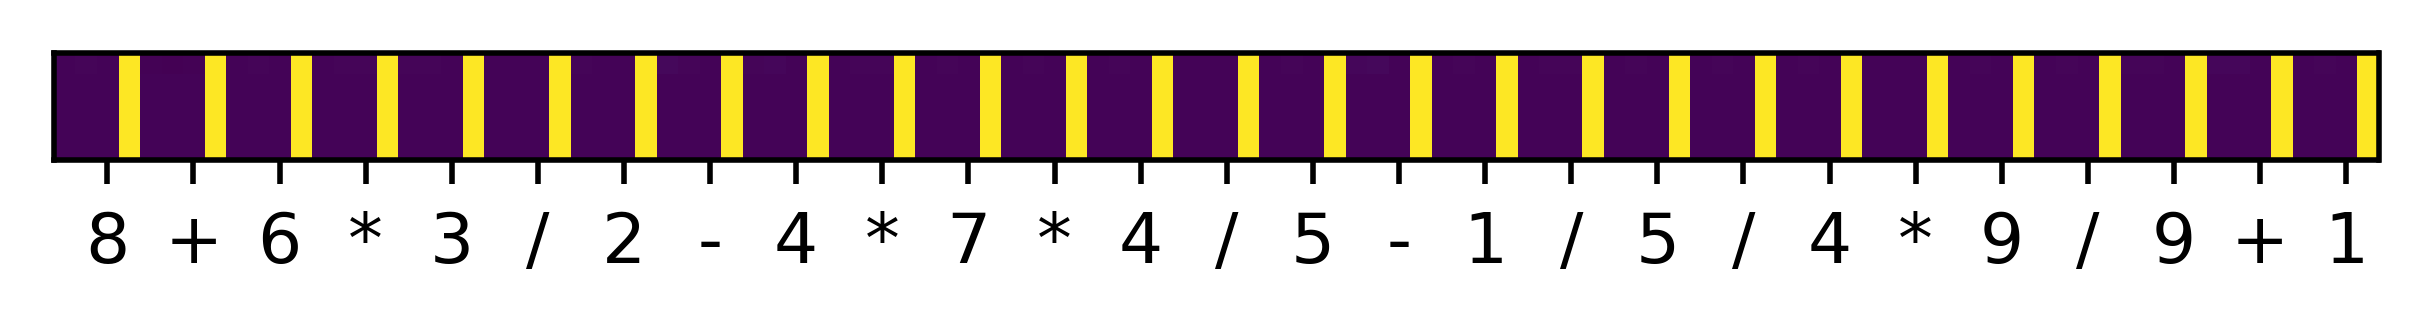

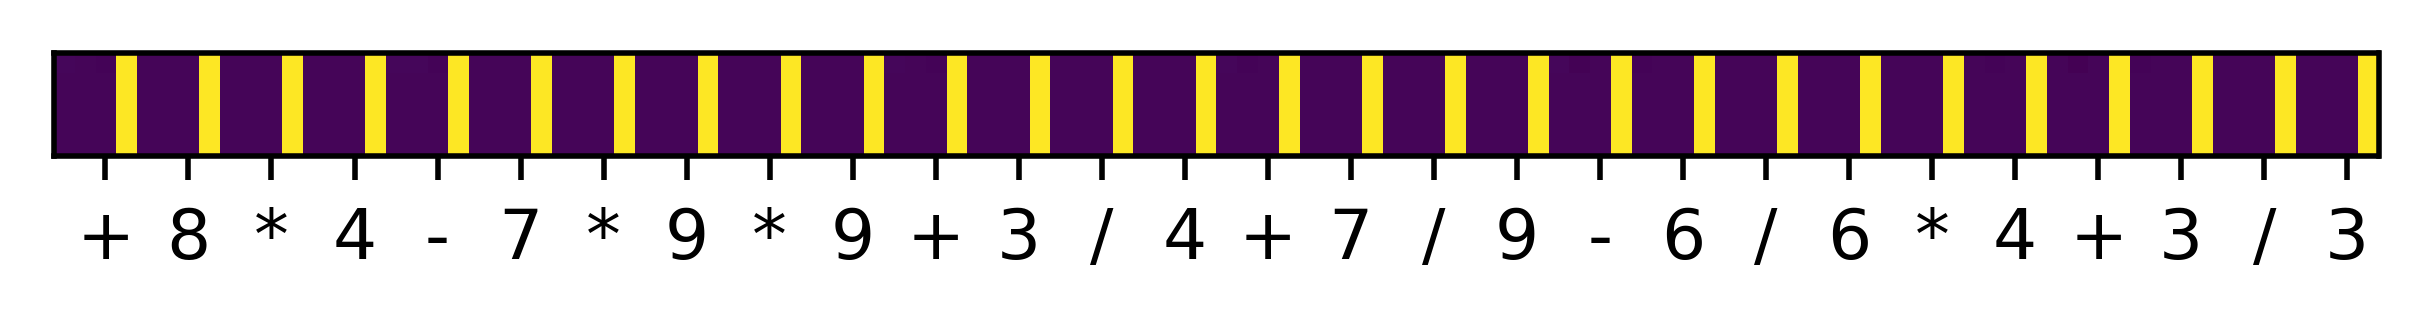

In [30]:
ncols = mem_whole.shape[1]
mid = seq_len // 2 * (remain + 1)
fig, ax = plt.subplots()
fig.dpi = 500
plt.imshow(mem_whole[:, :mid])
plt.xticks(np.arange(2, mem_whole.shape[1], 4)[:seq_len//2], list(seq)[:seq_len//2])
plt.yticks([])
plt.show()

fig, ax = plt.subplots()
fig.dpi = 500
plt.imshow(mem_whole[:, mid:])
plt.xticks(np.arange(2, mem_whole.shape[1], 4)[:seq_len-seq_len//2], list(seq)[seq_len//2:])
plt.yticks([])
plt.show()

In [10]:
in_l = {i:0 for i in range(seq_len)} 
in_r = {i:0 for i in range(seq_len)}
forget_l = {i:0 for i in range(seq_len)}
forget_r = {i:0 for i in range(seq_len)}
out_l = {i:0 for i in range(seq_len)}
out_r = {i:0 for i in range(seq_len)}
ngates = 0
hdim = 100

In [11]:
i = 0
with open('flang-analy_d23_ne10-sarnn_lstm-1543820247.txt', 'r') as f:
    for line in f:
        line_json = json.loads(line)
        t = line_json['t']
        ngates += 100
        for in_gate in line_json['i']:
            if in_gate > 0.9:
                in_r[t] += 1
            elif in_gate < 0.1:
                in_l[t] += 1
        
        for f_gate in line_json['f']:
            if f_gate > 0.9:
                forget_r[t] += 1
            elif f_gate < 0.1:
                forget_l[t] += 1
        
        for o_gate in line_json['o']:
            if o_gate > 0.9:
                out_r[t] += 1
            elif o_gate < 0.1:
                out_l[t] += 1

In [12]:
ngates = ngates/seq_len

In [13]:
ngates

50000.0

In [14]:
step = []
for i in range(seq_len):
    step.append(np.array(prob_action[i]))

In [15]:
mean_dist = []
for i in range(seq_len):
    mean_dist.append(step[i].sum(0)/step[i].shape[0])

In [18]:
# push = [mean_dist[t][6:].sum() for t in range(seq_len)]
push = [mean_dist[t][:6].sum() for t in range(seq_len)]

In [19]:
npop = []
for t in range(seq_len):
    pop = (mean_dist[t][:6] * np.arange(6)).sum() + \
        (mean_dist[t][6:] * np.arange(6)).sum()
    npop.append(pop)    

In [20]:
pop_normalized = np.array(npop) / 6

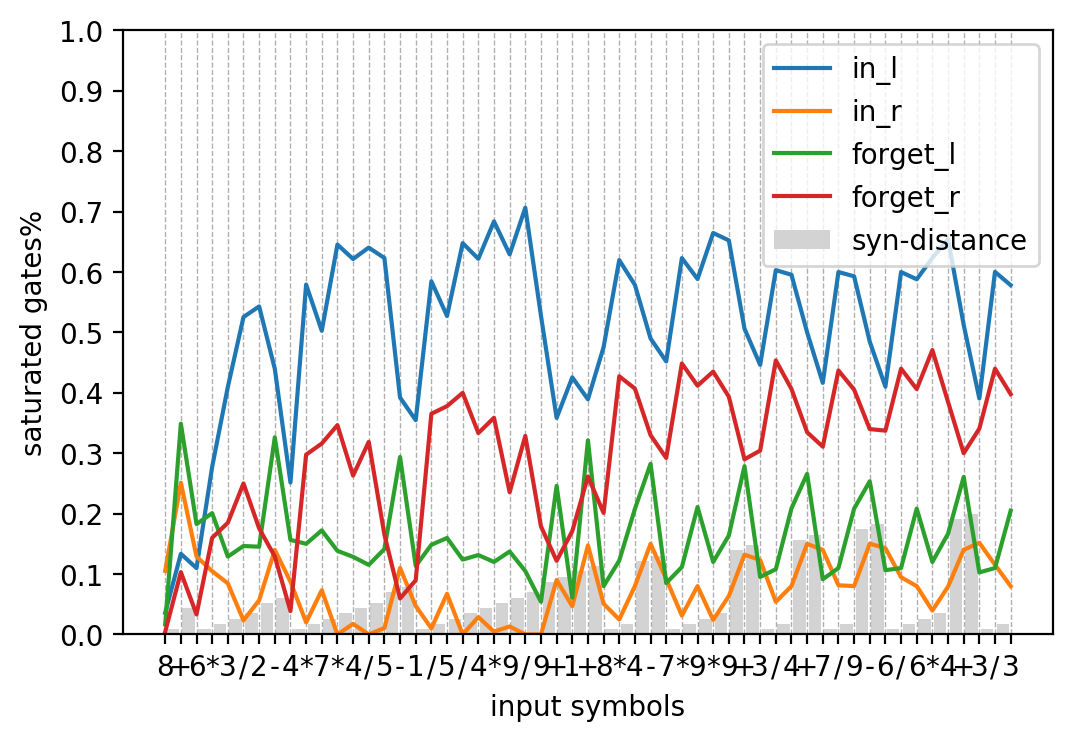

In [21]:
fig, ax = plt.subplots()
fig.dpi = 200
plt.grid(axis='x', linestyle='dashed', linewidth=0.5)
plt.plot(np.arange(seq_len), 
         np.array([in_l[i] for i in in_l.keys()])/ngates,
        label='in_l')
plt.plot(np.arange(seq_len), 
         np.array([in_r[i] for i in in_r.keys()])/ngates,
        label='in_r')
plt.plot(np.arange(seq_len), 
         np.array([forget_l[i] for i in forget_l.keys()])/ngates,
        label='forget_l')
plt.plot(np.arange(seq_len), 
         np.array([forget_r[i] for i in forget_r.keys()])/ngates,
        label='forget_r')

plt.bar(np.arange(0.5, seq_len-0.5), np.array(syn_dis)/max(syn_dis) * 0.2,
        label='syn-distance', color='lightgray')

plt.ylabel('saturated gates%')
plt.xlabel('input symbols')

plt.legend()
plt.xticks(np.arange(0, seq_len, 1), list(seq))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

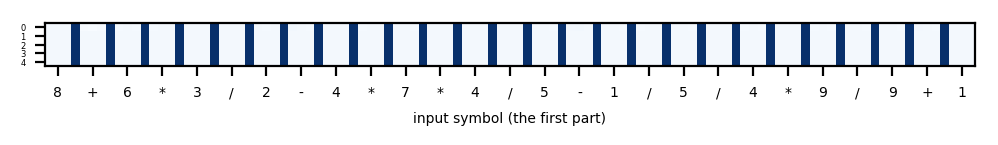

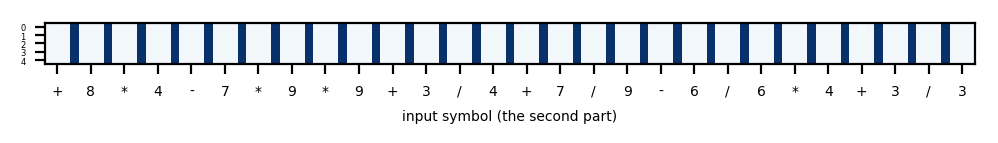

In [22]:
ncols = mem_whole.shape[1]
mid = seq_len // 2 * (remain + 1)
fig, ax = plt.subplots()
fig.dpi = 200
plt.imshow(mem_whole[:, :mid-1], cmap=plt.cm.Blues, vmax=0.7)
plt.xticks(np.arange(1, mem_whole.shape[1], 4)[:seq_len//2], list(seq)[:seq_len//2], fontsize=5)
plt.yticks(np.arange(5), fontsize=3)
plt.xlabel('input symbol (the first part)', fontsize=5)
plt.ylabel('')
plt.show()

fig, ax = plt.subplots()
fig.dpi = 200
plt.imshow(mem_whole[:, mid:-1], cmap=plt.cm.Blues, vmax=0.7)
plt.xticks(np.arange(1, mem_whole.shape[1], 4)[:seq_len-seq_len//2], list(seq)[seq_len//2:], fontsize=5)
plt.yticks(np.arange(5), fontsize=3)
plt.xlabel('input symbol (the second part)', fontsize=5)
plt.show()

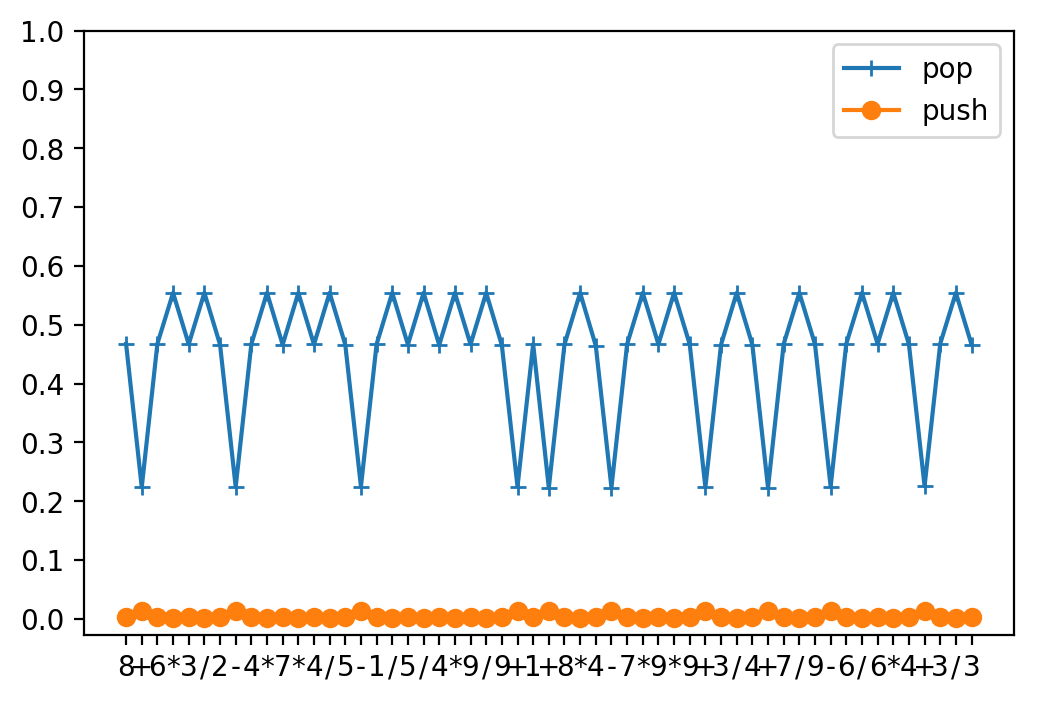

In [24]:
fig, ax = plt.subplots()
fig.dpi = 200

plt.plot(np.arange(seq_len), 
         pop_normalized,
        label='pop',marker='+')
plt.plot(np.arange(seq_len), 
         push,
        label='push',marker='o')

plt.legend()
plt.xticks(np.arange(0, seq_len, 1), list(seq))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

# lstm

In [33]:
in_l = {i:0 for i in range(seq_len)} 
in_r = {i:0 for i in range(seq_len)}
forget_l = {i:0 for i in range(seq_len)}
forget_r = {i:0 for i in range(seq_len)}
out_l = {i:0 for i in range(seq_len)}
out_r = {i:0 for i in range(seq_len)}
ngates = 0
hdim = 100

In [34]:
i = 0
nt = 0
nc = 0
with open('flang-analy_d23_ne10-lstm_lstm-1543827966.txt', 'r') as f:
    for line in f:
        line_json = json.loads(line)
        if line_json['type'] != 'gates':
            assert line_json['type'] == 'input'
            nc += line_json['is_correct']
            nt += 1
            continue 
        
        t = line_json['t']
        ngates += hdim
        for in_gate in line_json['i']:
            if in_gate > 0.9:
                in_r[t] += 1
            elif in_gate < 0.1:
                in_l[t] += 1
        
        for f_gate in line_json['f']:
            if f_gate > 0.9:
                forget_r[t] += 1
            elif f_gate < 0.1:
                forget_l[t] += 1
        
        for o_gate in line_json['o']:
            if o_gate > 0.9:
                out_r[t] += 1
            elif o_gate < 0.1:
                out_l[t] += 1

In [35]:
ngates = ngates/seq_len
ngates

50000.0

In [36]:
print('correct prediction%:', nc/nt)

correct prediction%: 1.0


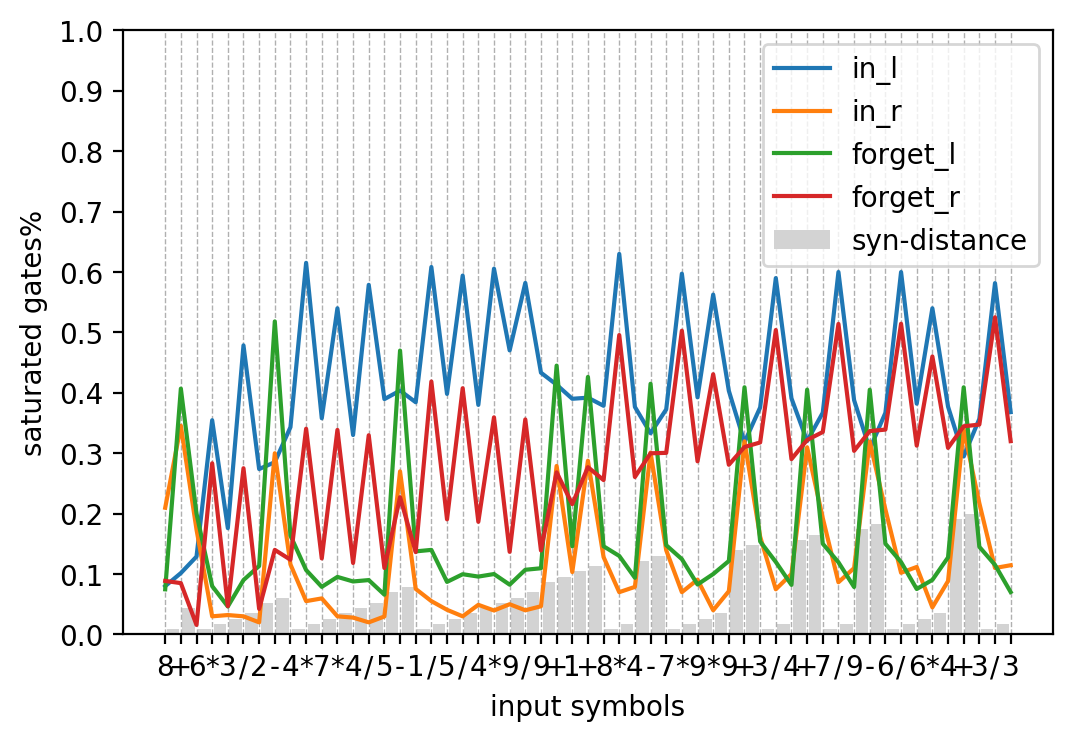

In [37]:
fig, ax = plt.subplots()
fig.dpi = 200
plt.grid(axis='x', linestyle='dashed', linewidth=0.5)
plt.plot(np.arange(seq_len), 
         np.array([in_l[i] for i in in_l.keys()])/ngates,
        label='in_l')
plt.plot(np.arange(seq_len), 
         np.array([in_r[i] for i in in_r.keys()])/ngates,
        label='in_r')
plt.plot(np.arange(seq_len), 
         np.array([forget_l[i] for i in forget_l.keys()])/ngates,
        label='forget_l')
plt.plot(np.arange(seq_len), 
         np.array([forget_r[i] for i in forget_r.keys()])/ngates,
        label='forget_r')

plt.bar(np.arange(0.5, seq_len-0.5), np.array(syn_dis)/max(syn_dis) * 0.2,
        label='syn-distance', color='lightgray')

plt.ylabel('saturated gates%')
plt.xlabel('input symbols')

plt.legend()
plt.xticks(np.arange(0, seq_len, 1), list(seq))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

# alstm

In [38]:
a = {i:[] for i in range(seq_len)}
window_size = 10
i = 0
nc = 0
nt = 0
with open('flang-analy_d23_ne10-alstm-1543828321.txt', 'r') as f:
    for line in f:
        line_json = json.loads(line)
        if 'a' not in line_json:
            nc += line_json['is_correct']
            nt += 1
            i = 0
            continue
        
        vec = [0] * seq_len
        atten = line_json['a']
        vec[i-len(atten):i] = atten
#         if len(atten) > 0:
#         vec[i+1-len(atten):i+1] = atten
        a[i].append(vec)
        i += 1

In [39]:
nc/nt

1.0

In [40]:
a_temp = {i:[] for i in range(seq_len)}
for i in range(seq_len):
    a_temp[i] = np.array(a[i]).sum(0)/len(a[i])

In [41]:
len(a[10][1])

55

In [42]:
attens = np.array([a_temp[i] for i in range(seq_len)])

In [44]:
attens.shape

(55, 55)

Text(0.5,0,'input symbol')

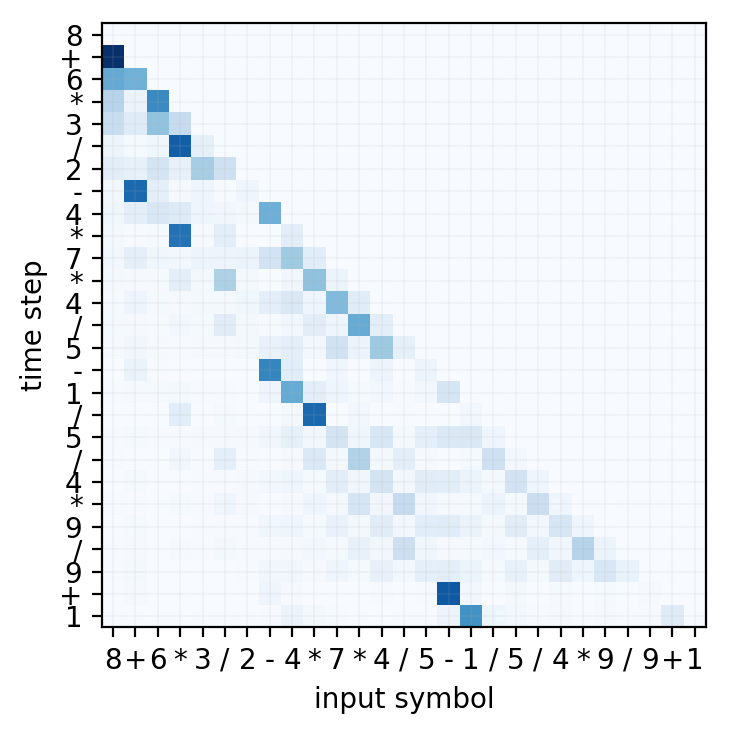

In [46]:
fig, ax = plt.subplots()
fig.dpi = 200
kept = 27
# plt.title('attention')
plt.imshow(attens[:kept, :kept], cmap=plt.cm.Blues)
#            , interpolation='gaussian')
plt.xticks(np.arange(seq_len)[:kept], list(seq)[:kept], fontsize=10)
plt.ylabel('time step')
plt.yticks(np.arange(seq_len)[:kept], list(seq)[:kept], fontsize=10)
plt.grid(linestyle='dashed', linewidth=0.1)
# plt.yticks(np.arange(0, seq_len, 3))
plt.xlabel('input symbol')

# ntm